In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import os
from pathlib import Path


In [18]:
def load_and_prepare(census_path, survey_path):
    """Load and merge datasets with suffixes"""
    census = pd.read_csv(census_path)
    survey = pd.read_csv(survey_path)
    return pd.merge(census, survey, on='geography_code', 
                   suffixes=('_census', '_survey'))

In [19]:
def extract_variable_group(merged_df, prefix):
    """
    Extract geography_code and all columns starting with given prefix
    into a new DataFrame
    
    Parameters:
    - merged_df: DataFrame from load_and_prepare()
    - prefix: Variable prefix to extract (e.g. 's01_')
    
    Returns:
    - DataFrame with geography_code and matching columns
    """
    # Find all columns matching the prefix
    cols = [col for col in merged_df.columns 
           if col.startswith(prefix) or col == 'geography_code']
    
    return merged_df[cols].copy()

In [20]:
def normalize_by_half_row_total(df):
    """
    Creates a new DataFrame with values normalized by 0.5 of row totals
    (excluding geography_code)
    
    Parameters:
        df: Input DataFrame with geography_code and value columns
        
    Returns:
        New DataFrame with geography_code and normalized values only
    """
    # Create new empty DataFrame with just geography_code
    norm_df = pd.DataFrame()
    norm_df['geography_code'] = df['geography_code']
    
    # Get all columns except geography_code
    value_cols = [col for col in df.columns if col != 'geography_code']
    
    # Calculate row totals (sum of census + survey values)
    row_totals = df[value_cols].sum(axis=1)
    
    # Add normalized columns to new DF
    for col in value_cols:
        norm_df[col] = df[col] / (0.5 * row_totals)
    
    return norm_df

In [21]:
def ensure_directory_exists(directory_path):
    """
    Check if a directory exists, and create it if it doesn't.
    
    Args:
        directory_path (str): The path to the directory to check/create
    """
    # Convert to Path object for easier handling
    path = Path(directory_path)
    
    # Check if the directory already exists
    if not path.exists():
        # Create the directory (and any parent directories if needed)
        path.mkdir(parents=True, exist_ok=True)
        print(f"Created directory: {directory_path}")
    
    
    return path.exists()

In [22]:
def hist_census_vs_survey(df,directory, group):
    ensure_directory_exists(directory)
     # Find all columns with '_census' and '_survey'
    census_cols = [col for col in df.columns if '_census' in col]
    survey_cols = [col.replace('_census', '_survey') for col in census_cols]
    
    # Check if matching survey columns exist
    valid_pairs = []
    for c_col, s_col in zip(census_cols, survey_cols):
        if s_col in df.columns:
            valid_pairs.append((c_col, s_col))
    
    if not valid_pairs:
        raise ValueError("No matching '_census' and '_survey' columns found!")
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(valid_pairs)))  # Different colors    
    
    # Set up a figure with two subplots: scatter (left) and histogram (right)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    # --- Scatter Plot (Left) ---
    for (c_col, s_col), color in zip(valid_pairs, colors):
        label = c_col.split('%')[-1].replace('_census', '')
        ax1.scatter(df[c_col], df[s_col], color=color, label=label, alpha=0.7, s=0.5)
    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect Agreement')
    ax1.set_title('Census vs. Survey: ' + group)
    ax1.legend(
        bbox_to_anchor=(1.05, 1),  # Places legend outside the plot
        loc='upper left',           # Anchors the legend
        markerscale=10,             # Scales up legend markers
        frameon=True,               # Optional: adds a border
        title='Data Sources'        # Optional: adds a legend title
    )

    # ... (rest of your scatter setup) ...

    # --- Signed Deviation Histogram (Right) ---
    deviations = []
    for c_col, s_col in valid_pairs:
        deviations.extend(df[s_col] - df[c_col])  # Signed: survey - census
    
    # Custom binning for positive/negative deviations
    max_dev = max(abs(min(deviations)), abs(max(deviations)))
    bins = np.linspace(-max_dev, max_dev, 31)  # Symmetric around zero
    
    ax2.hist(deviations, bins=bins, color='lightgreen', edgecolor='black', alpha=0.7)
    ax2.axvline(0, color='red', linestyle='--', linewidth=1)  # Zero reference
    ax2.set_xlabel('Survey - Census (Signed Deviation)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Directional Deviations')
    ax2.set_xlim(left=-0.4, right=0.4)
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'{directory}{group}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
def hist_data(group):
    urban_rural_df = extract_variable_group(df,group)
    urban_rural_norm = normalize_by_half_row_total(urban_rural_df)
    hist_census_vs_survey(urban_rural_norm,"results/graphs/sand/",group)
    #hist_census_vs_survey(urban_rural_norm,"results/graphs/ScotHousingEducation/",group)


<Figure size 800x600 with 0 Axes>

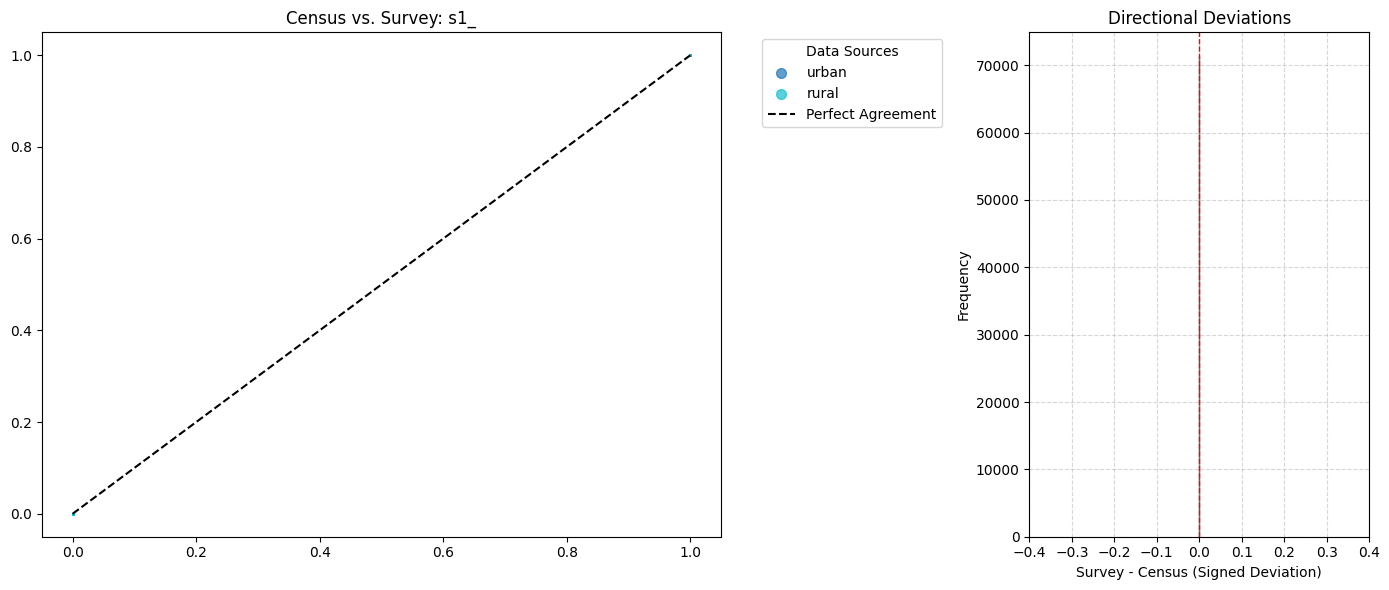

<Figure size 800x600 with 0 Axes>

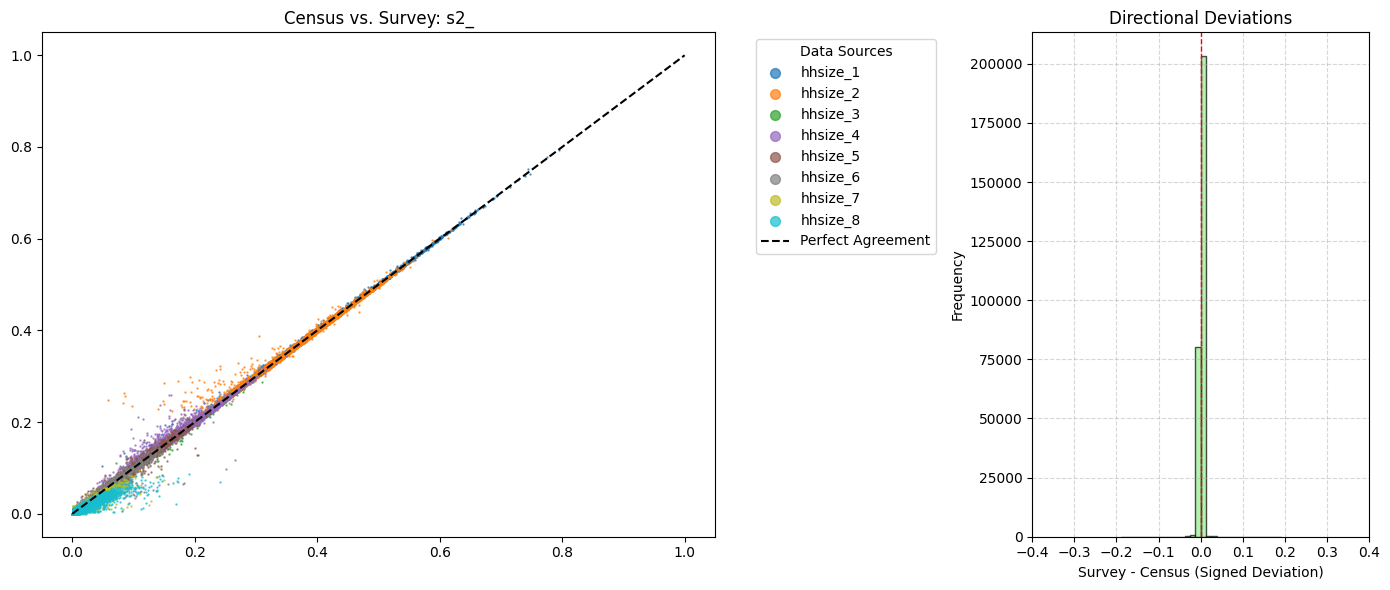

<Figure size 800x600 with 0 Axes>

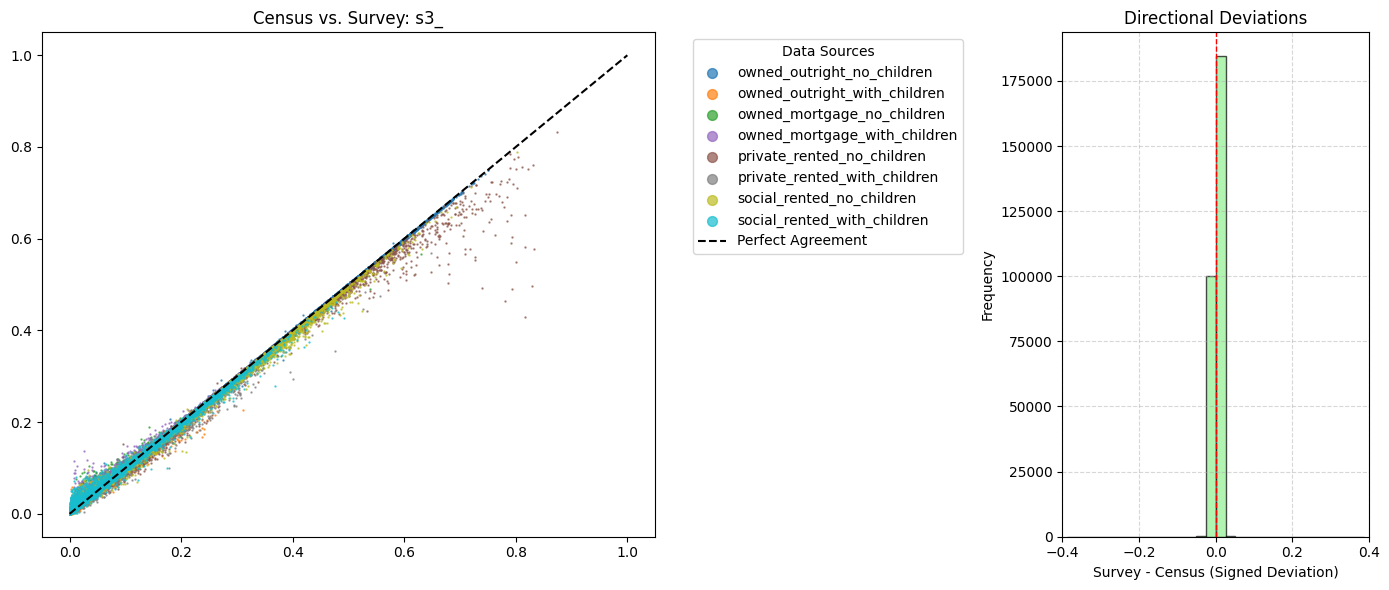

<Figure size 800x600 with 0 Axes>

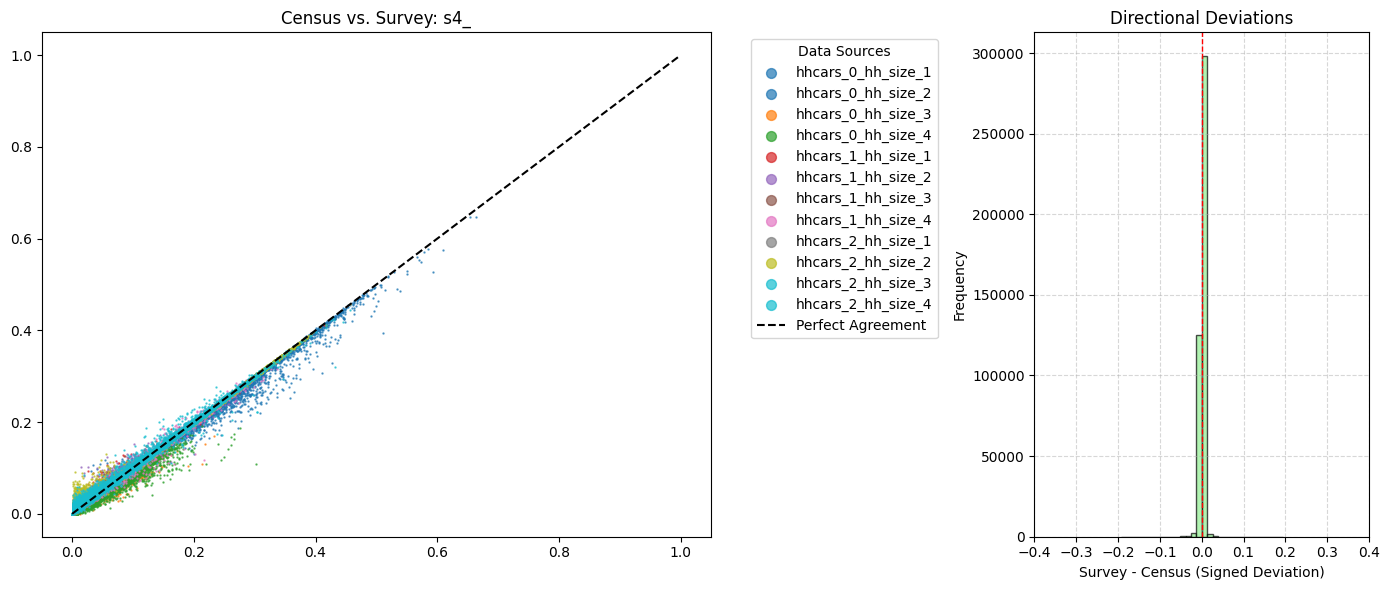

<Figure size 800x600 with 0 Axes>

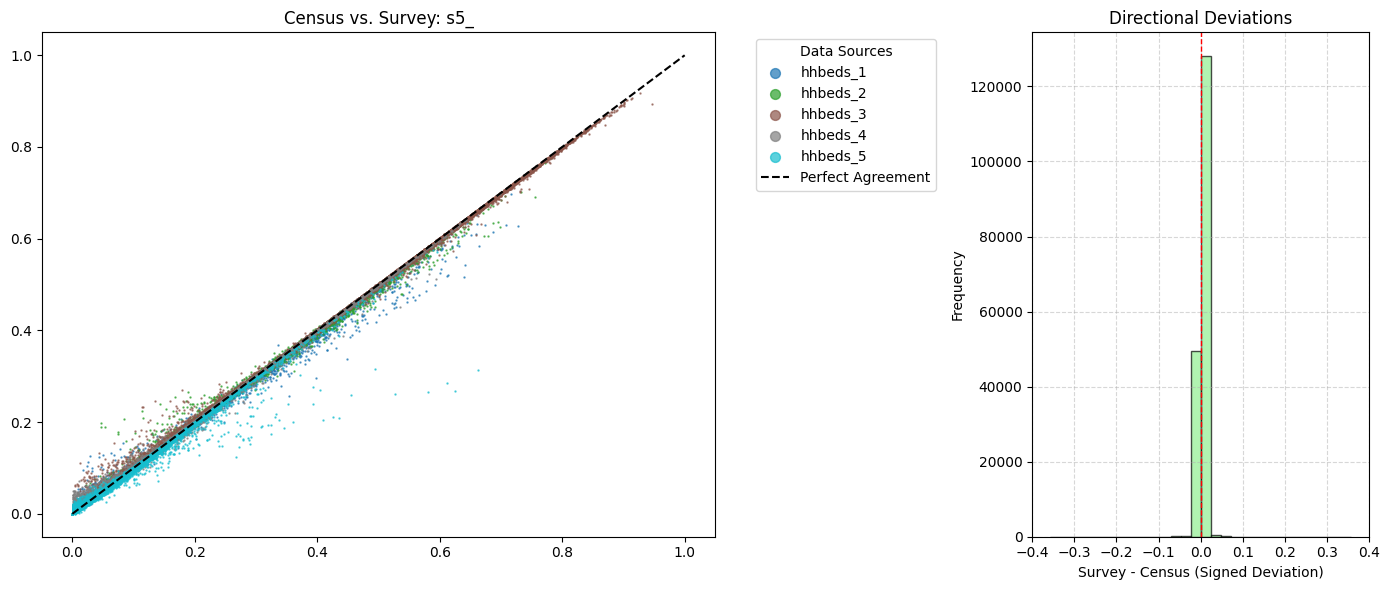

<Figure size 800x600 with 0 Axes>

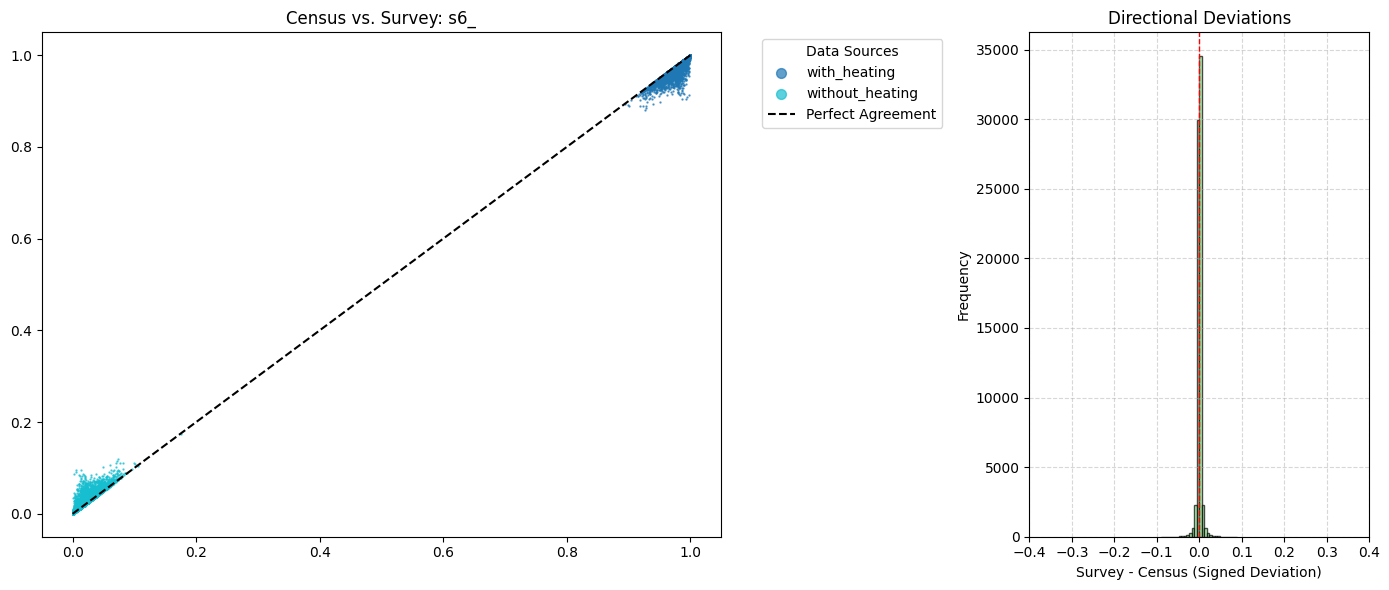

<Figure size 800x600 with 0 Axes>

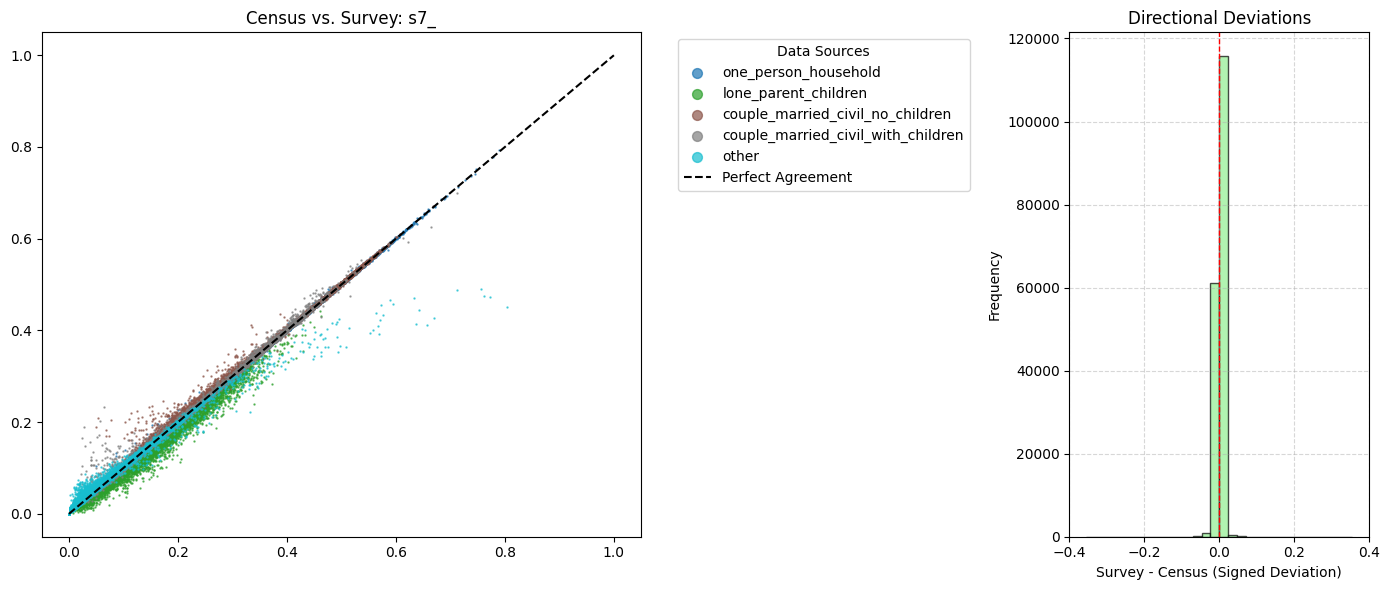

<Figure size 800x600 with 0 Axes>

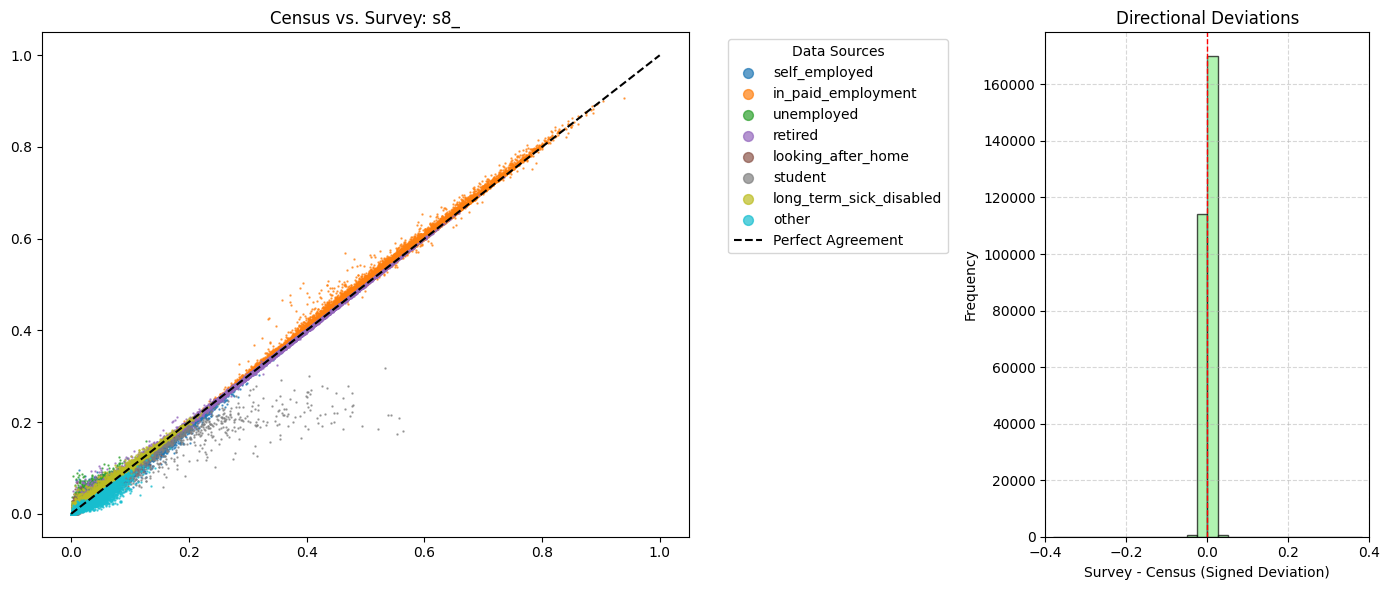

<Figure size 800x600 with 0 Axes>

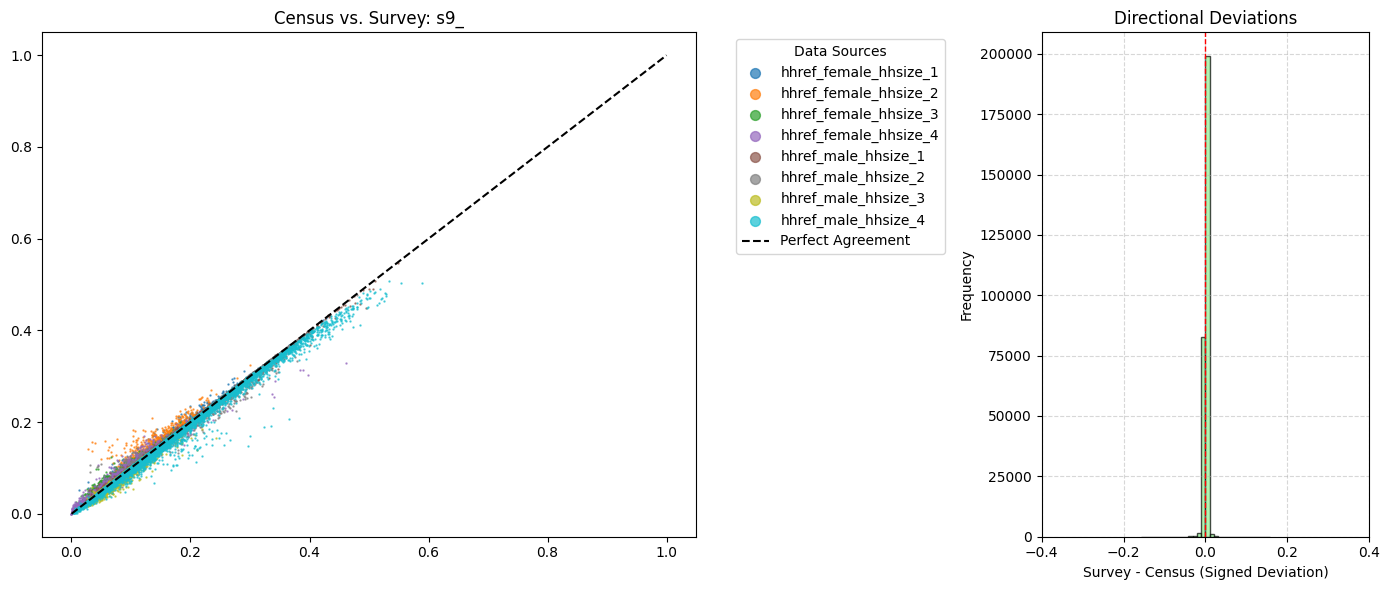

<Figure size 800x600 with 0 Axes>

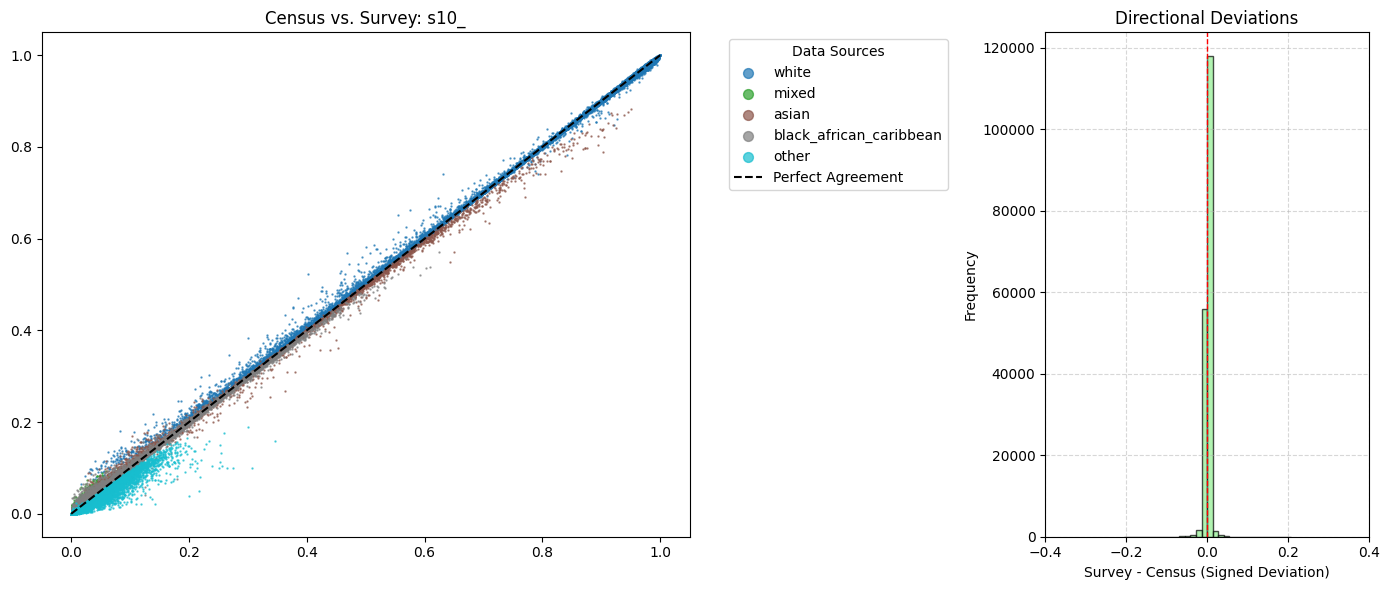

<Figure size 800x600 with 0 Axes>

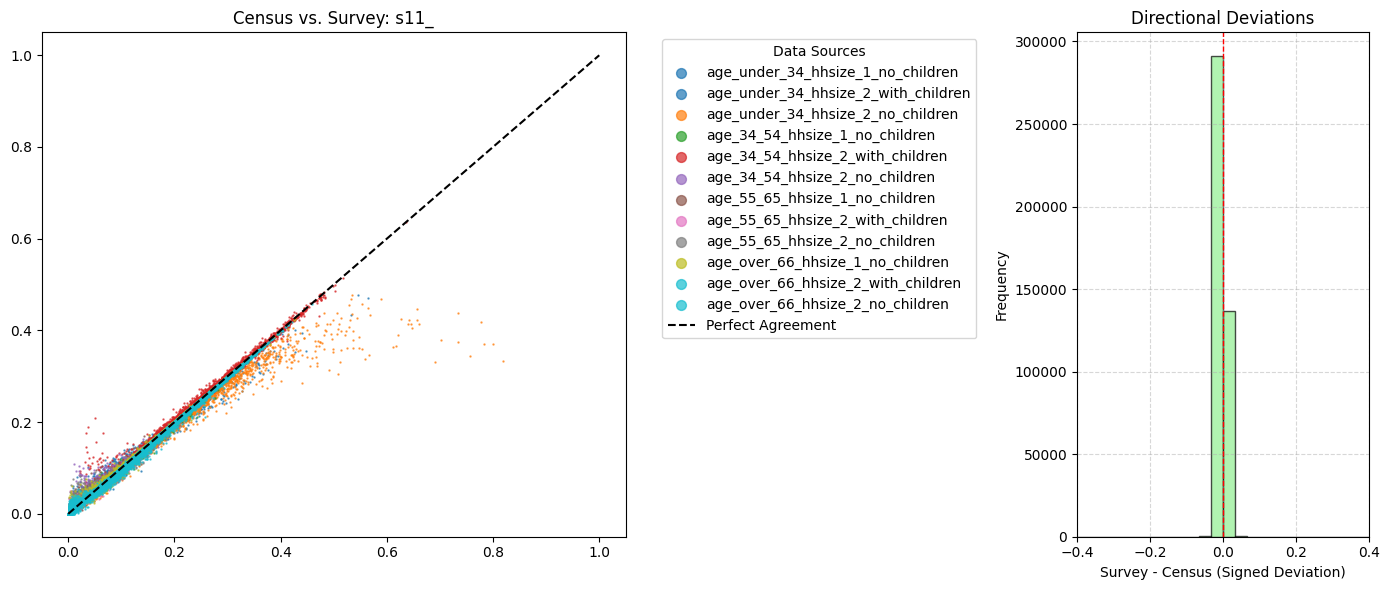

<Figure size 800x600 with 0 Axes>

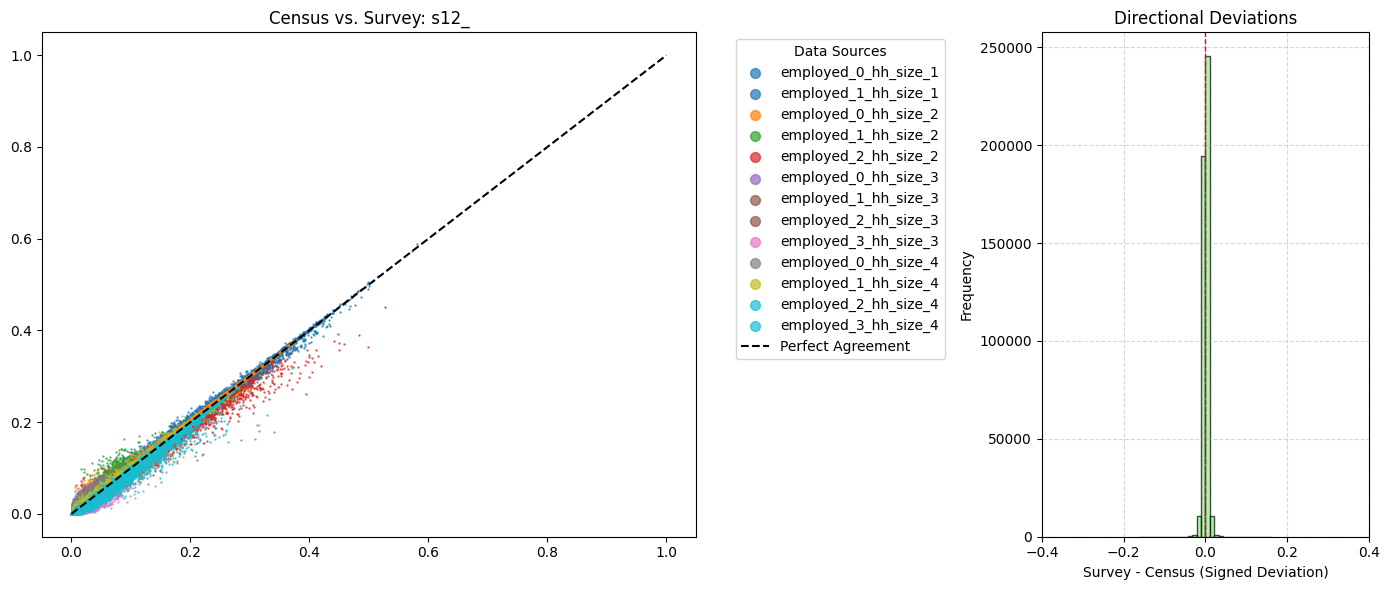

<Figure size 800x600 with 0 Axes>

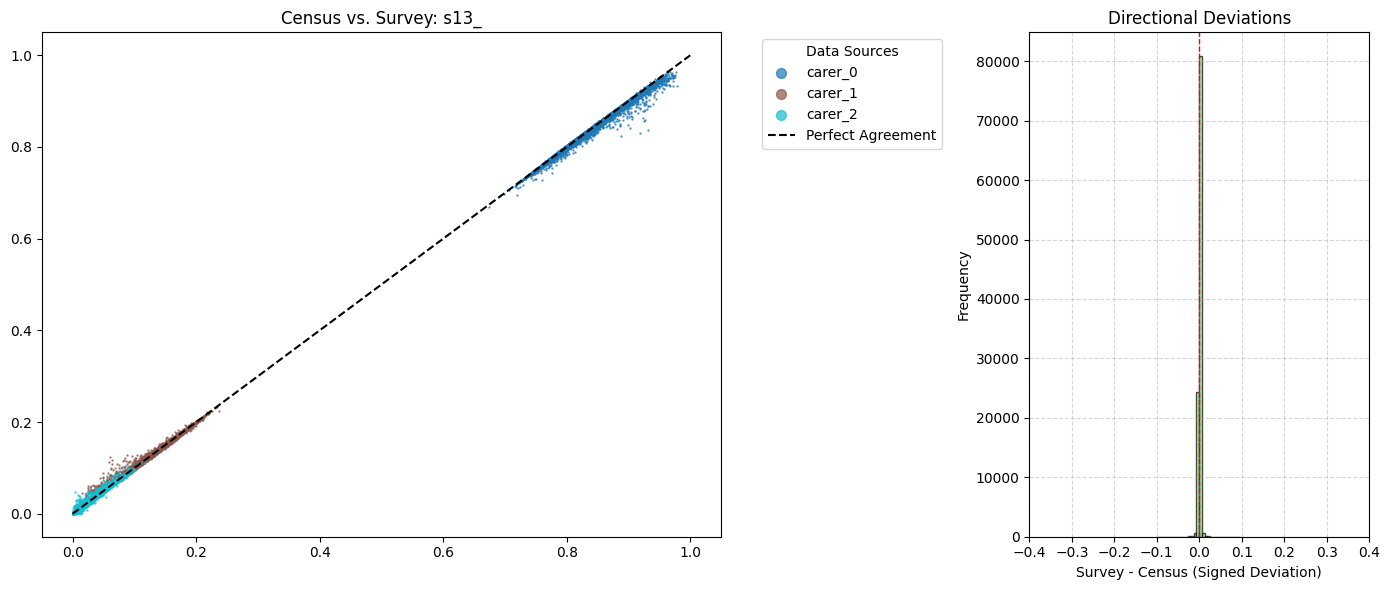

<Figure size 800x600 with 0 Axes>

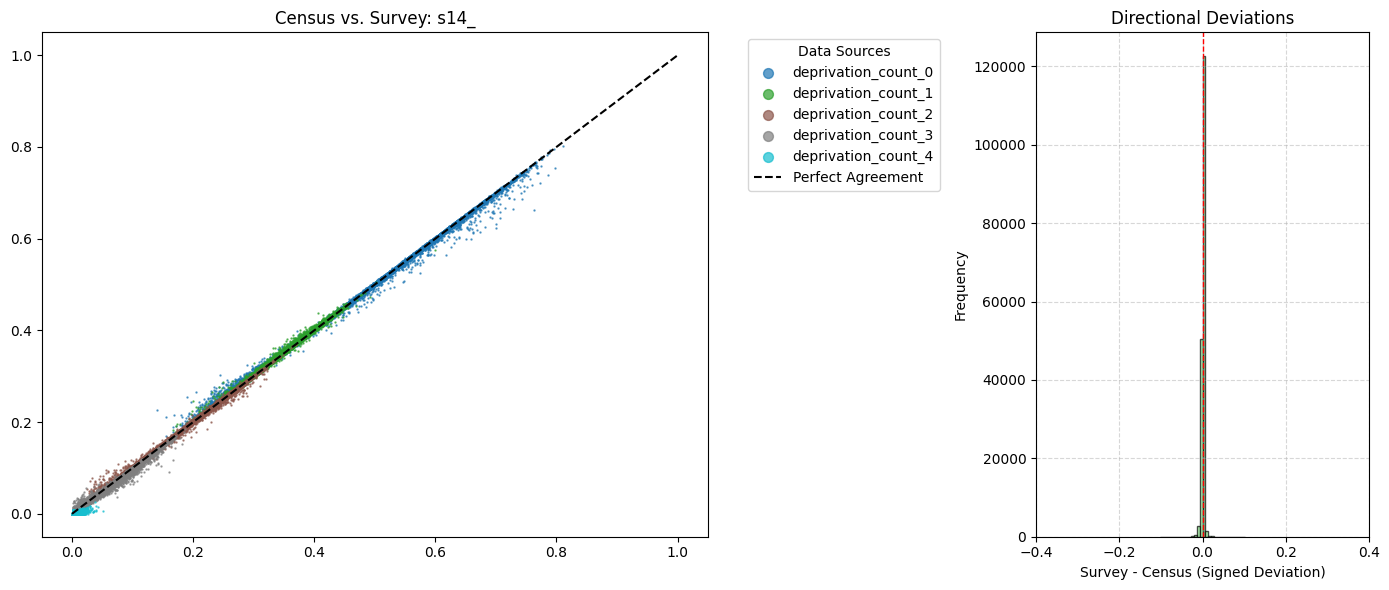

In [24]:
df = load_and_prepare('data/england_wales_constraint_targets_counts_individuals_1808.csv', 'results/ukw_synthPopSurvay1808.csv')
for g in ['s1_','s2_','s3_','s4_','s5_','s6_','s7_','s8_','s9_','s10_','s11_','s12_','s13_','s14_']:
    hist_data(g)
# df = load_and_prepare('data/census2022_all_go.csv', 'results/synthPopSurvay0608.csv')
# for g in ['s01_','s02_','s03_','s04_','s05_','s06_','s07_','s08_','s09_','s10_','s11_','s12_','s13_','s14_']:
#     hist_data(g)    